In [46]:
import os
import sys
#import wget
from datetime import datetime, timedelta
import xarray as xr
from zipfile import ZipFile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from metpy.plots import USCOUNTIES
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Note: In addition to the packages listed above, cfgrib will also need to be installed

In [47]:
import s3fs
import boto3
import botocore
from botocore.client import Config

In [53]:
# Select start date (in UTC)
year = 2025
month = 6
day = 18
hour = 16
# Select length of time to run (hours)
length = 9

##########################
dt_list = []
start_dt = datetime(year, month, day, hour)
for hn in np.arange(0, length+1, 1):
    new_time = start_dt + timedelta(hours=int(hn))
    dt_list.append(new_time)

date_strings = []
hours = []
for dts in np.arange(0, len(dt_list), 1):
    dt_c = dt_list[dts]
    ys = f'{dt_c.year}'
    if month < 10:
        ms = f'0{dt_c.month}'
    else:
        ms = f'{dt_c.month}'
    if day < 10:
        ds = f'0{dt_c.day}'
    else:
        ds = f'{dt_c.day}'
    date_s = f'{ys}{ms}{ds}'
    date_strings.append(date_s)

    hours.append(dt_c.hour)

    if dts == 0:
        ys_spc = ys
        ms_spc = ms
        ds_spc = ds

times = []
for h in hours:
    t = h*30
    times.append(t)

if year < 2020:
    print('Error: Date is outside the range available in the AWS archive')
elif year == 2020 and month < 10:
    print('Error: Date is outside the range available in the AWS archive')
elif year == 2020 and month == 10 and day < 14:
    print('Error: Date is outside the range available in the AWS archive')


##########
torn_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{ys_spc[2:]}{ms_spc}{ds_spc}_rpts_torn.csv')
wind_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{ys_spc[2:]}{ms_spc}{ds_spc}_rpts_wind.csv')
hail_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{ys_spc[2:]}{ms_spc}{ds_spc}_rpts_hail.csv')

In [5]:
# # Select Date
# year = 2025
# month = 6
# day = 18
# # Select times (in UTC)
# hours = [16, 17, 18, 19, 20, 21, 22, 23]

# #########################
# ys = f'{year}'
# if month < 10:
#     ms = f'0{month}'
# else:
#     ms = f'{month}'
# if day < 10:
#     ds = f'0{day}'
# else:
#     ds = f'{day}'
# date_string = f'{ys}{ms}{ds}'

# times = []
# for hour in hours:
#     t = hour*30
#     times.append(t)
    
# if year < 2020:
#     print('Error: Date is outside the range available in the AWS archive')
# elif year == 2020 and month < 10:
#     print('Error: Date is outside the range available in the AWS archive')
# elif year == 2020 and month == 10 and day < 14:
#     print('Error: Date is outside the range available in the AWS archive')


# ##########
# torn_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{ys[2:]}{ms}{ds}_rpts_torn.csv')
# wind_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{ys[2:]}{ms}{ds}_rpts_wind.csv')
# hail_reports = pd.read_csv(f'https://www.spc.noaa.gov/climo/reports/{ys[2:]}{ms}{ds}_rpts_hail.csv')

In [54]:
s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED,
                                        user_agent_extra='Resource'))
bucket = s3.Bucket('noaa-mrms-pds')
aws = s3fs.S3FileSystem(anon=True)
file_list = []
file_list_2 = []
os.system(f'mkdir temp_ncfiles')


df_dates = pd.DataFrame()
df_dates['datestring'] = date_strings
df_dates['hours'] = times

for dts in set(date_strings):
    sub_df = df_dates[df_dates['datestring']==dts]
    sub_times = list(sub_df.hours)
    os.system(f'mkdir {dts}')

    file_names = []
    file_list_short = []
    for obj in bucket.objects.filter(Prefix=f'CONUS/MergedBaseReflectivityQC_00.50/{dts}'):
        #print(obj.key)
        file_names.append(obj.key)
    for i in sub_times:
        name_file = f'{dts[:4]}_{dts[4:6]}_{dts[6:]}_{file_names[i][91:97]}.grib2.gz'
        aws.get(f'noaa-mrms-pds/{file_names[i]}', f'{dts}/{name_file}')
        file_list.append(name_file)
        file_list_short.append(name_file)

    for j in file_list_short:
        os.system(f'gunzip {dts}/{j}')
        #os.system(f'rm -r AWS/{j}')

    file_list_2_short = []

    for k in file_list_short:
        temp = k[:23]
        file_list_2_short.append(temp)
        file_list_2.append(temp)

    for m in file_list_2_short:
        # Open grib file using xarray
        filepath = f'{dts}/{m}'
        ds1 = xr.open_dataset(filepath, engine="cfgrib")
        #ds1 = ds1.rename(unknown='Reflectivity')
        radar_data = ds1['unknown']
        radar_data.to_netcdf(path=f'temp_ncfiles/{m[:17]}.nc')

ECCODES ERROR   :  Truncating time: non-zero seconds(12) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(12) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(20) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(20) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Trunca

In [ ]:
# aws = s3fs.S3FileSystem(anon=True)
# file_list = []
# os.system(f'mkdir {date_string}')
# os.system(f'mkdir {date_string}/ncfiles')

# s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED,
#                                         user_agent_extra='Resource'))
# bucket = s3.Bucket('noaa-mrms-pds')
# file_names = []
# for obj in bucket.objects.filter(Prefix=f'CONUS/MergedBaseReflectivityQC_00.50/{date_string}'):
#     #print(obj.key)
#     file_names.append(obj.key)

# for i in times:
#     name_file = f'{ys}_{ms}_{ds}_{file_names[i][91:97]}.grib2.gz'
#     aws.get(f'noaa-mrms-pds/{file_names[i]}', f'{date_string}/{name_file}')
#     file_list.append(name_file)

In [8]:
# for j in file_list:
#     os.system(f'gunzip {date_string}/{j}')
#     #os.system(f'rm -r AWS/{j}')

In [9]:
# file_list_2 = []

# for k in file_list:
#     temp = k[:23]
#     file_list_2.append(temp)

In [10]:
# for m in file_list_2:
#     # Open grib file using xarray
#     filepath = f'{date_string}/{m}'
#     ds1 = xr.open_dataset(filepath, engine="cfgrib")
#     #ds1 = ds1.rename(unknown='Reflectivity')
#     radar_data = ds1['unknown']
#     radar_data.to_netcdf(path=f'{date_string}/ncfiles/{m[:17]}.nc')

ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(20) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(20) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(13) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(15) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(15) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(17) ignored
ECCODES ERROR   :  Trunca

In [56]:
comp = np.zeros((3500, 7000))
#comp = np.zeros((700, 1400))

for m in file_list_2:
    ds_temp = xr.open_dataset(f'temp_ncfiles/{m[:17]}.nc')
    data = ds_temp.unknown.data
    
    comp = np.maximum(comp, data)
    
comp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
# comp = np.zeros((3500, 7000))
# #comp = np.zeros((700, 1400))

# for m in file_list_2:
#     ds_temp = xr.open_dataset(f'{date_string}/ncfiles/{m[:17]}.nc')
#     data = ds_temp.unknown.data
    
#     comp = np.maximum(comp, data)
    
# comp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
# Open any file to get geographic data
ds_new = xr.open_dataset(f'temp_ncfiles/{file_list_2[0][:17]}.nc')

In [64]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

custom_color = ListedColormap(["darkgreen", "green", "limegreen", "yellow", "gold", "orange", "orangered", "red", "firebrick", "blueviolet"])

In [65]:
comp_threshold = comp
comp_threshold[comp_threshold<25]=-1

datetime.datetime(2025, 6, 19, 1, 0)

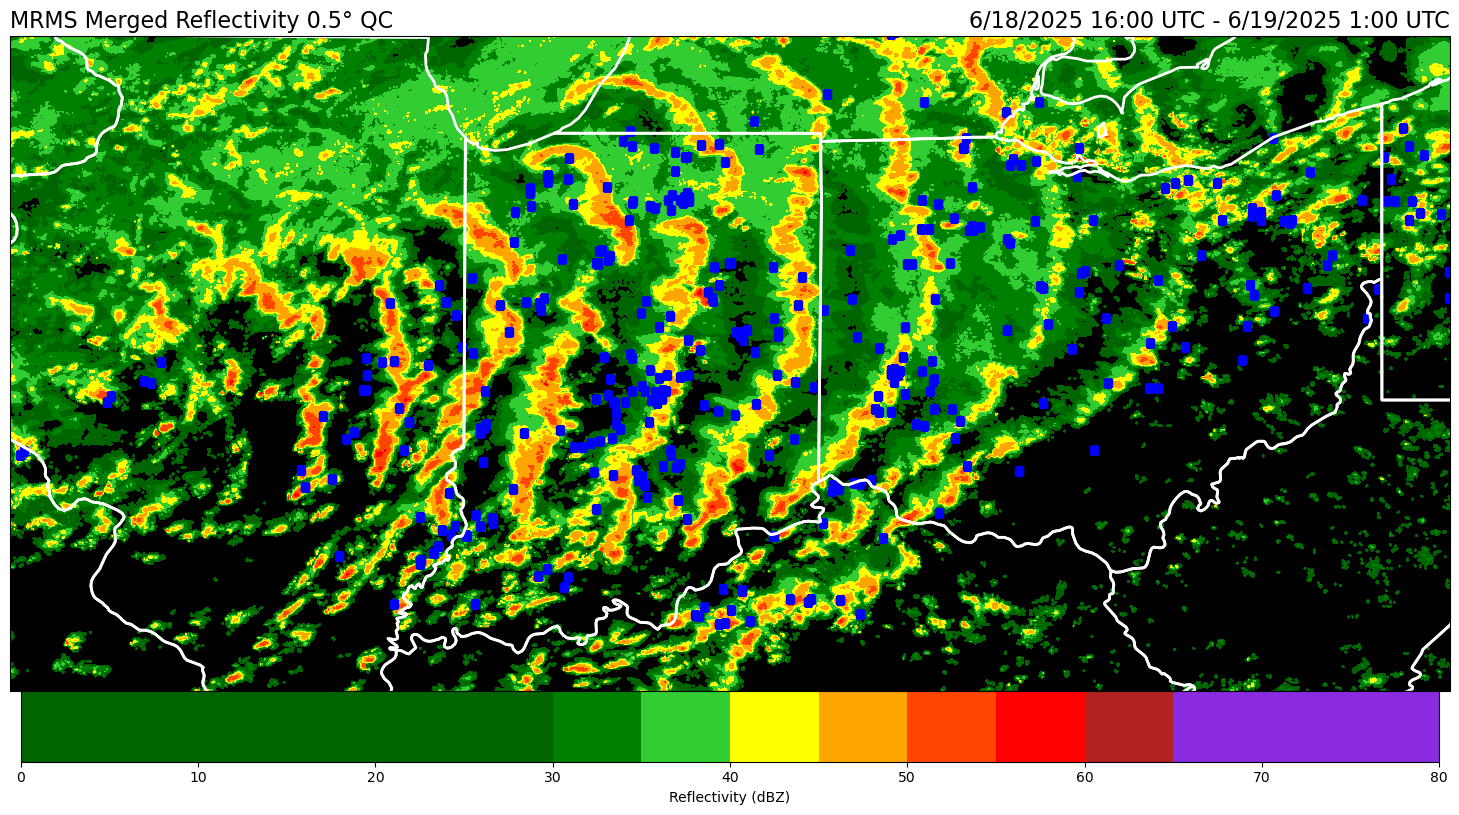

In [75]:
dt_start = dt_list[0]
dt_end = dt_list[-1]

lats = ds_new.latitude
lons = ds_new.longitude
# Set projections
map_crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
data_crs = ccrs.PlateCarree()
# Set up figure and axis
fig = plt.figure(1, figsize=(20,10), facecolor='w')
ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_extent([-91, -80, 37.5, 42.5], data_crs)
# Set max and min values to be displayed on map
vmin = 5
vmax = 80
levels = np.linspace(0, 80, 17)
# Plot data
im = ax.contourf(lons, lats, comp_threshold, transform=data_crs, 
                    cmap=custom_color, levels=levels, vmin=25, vmax=70)
ax.scatter(torn_reports.Lon, torn_reports.Lat, color='red', transform=data_crs, marker='v')
ax.scatter(wind_reports.Lon, wind_reports.Lat, color='blue', transform=data_crs, marker='s')
ax.scatter(hail_reports.Lon, hail_reports.Lat, color='green', transform=data_crs, marker='o')

# Add any helpful map overlays
#ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='darkgray')
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='white', linewidth=2)
ax.set_facecolor('black')
# Create plot title and colorbar
#plt.title('GridRad Column Max Reflectivity', loc='left')
#plt.title(f'{month}/{day}/{year} {hour}:00', loc='right')
cb = plt.colorbar(im, orientation='horizontal', pad=0, shrink=0.915)
cb.set_label('Reflectivity (dBZ)', fontsize=10)
#plt.text(-94.6, 37.7, '@EWolffWX', color='w', fontsize=20, fontweight='bold')
plt.title('MRMS Merged Reflectivity 0.5° QC', loc='left', fontsize=16)
plt.title(f'{dt_start.month}/{dt_start.day}/{dt_start.year} {dt_start.hour}:00 UTC - {dt_end.month}/{dt_end.day}/{dt_end.year} {dt_end.hour}:00 UTC', loc='right', fontsize=16)
plt.savefig(f'{date_strings[0]}_Composite.png', dpi=300, bbox_inches='tight')

plt.show()